In [ ]:
import open3d as o3d
import numpy as np
import util
from preprocess import preProcessData
from BendLength import BendLengthCalculator

def project_point_onto_plane(point, plane_model):
    normal = np.array(plane_model[:3])
    d = plane_model[3]
    normal = normal / np.linalg.norm(normal)
    distance = np.dot(normal, point) + d
    return point - distance * normal

def project_point_onto_line(point, line_point, line_dir):
    """
    Projects a point onto a 3D line defined by a point and direction.
    """
    line_dir = line_dir / np.linalg.norm(line_dir)
    vec_to_point = point - line_point
    projection_length = np.dot(vec_to_point, line_dir)
    projected = line_point + projection_length * line_dir
    return projected

def make_sphere(p, color, r=0.1):
    s = o3d.geometry.TriangleMesh.create_sphere(radius=r)
    s.translate(p)
    s.paint_uniform_color(color)
    return s

def make_arrow(start, end, color):
    line = o3d.geometry.LineSet()
    line.points = o3d.utility.Vector3dVector([start, end])
    line.lines = o3d.utility.Vector2iVector([[0, 1]])
    line.colors = o3d.utility.Vector3dVector([color])
    return line

def draw_intersection_line(intersection_line, length=350, color=[1, 0, 0]):
    direction = np.array(intersection_line[0])
    point_on_line = np.array(intersection_line[1])
    start = point_on_line - length / 2 * direction
    end = point_on_line + length / 2 * direction
    return make_arrow(start, end, color)

# --- Load and process ---
point_cloud_location = "/home/chris/Code/PointClouds/data/FLIPscans/Bendy/Bendy_1/scan1_Part1.ply"
pcd = o3d.io.read_point_cloud(point_cloud_location)

mesh = o3d.io.read_triangle_mesh("/home/chris/Code/PointClouds/data/FLIPscans/Bendy/BendyCAD.STL")
mesh.compute_vertex_normals()
pcd, avg_density, cad_pcd = preProcessData(pcd, mesh, x_rotation=110, y_rotation=0, z_rotation=90)

pcd_tree = o3d.geometry.KDTreeFlann(pcd)

segment_models, segments, segment_indices, main_surface_idx = util.multiOrderRansacAdvanced(
    pcd, pt_to_plane_dist=0.4, verbose=False, visualize=False
)
intersection_lines = util.findIntersectionLinesLeastSquares(segment_models, main_surface_idx)
angles_rad = util.findAnglesBetweenPlanes(segment_models, main_surface_idx)
anchor_points = util.findAnchorPoints(segment_models, segments, intersection_lines, main_surface_idx)

sample_dist = 0.2
aggregation_range = 5
eigen_threshold = 0.07
angle_threshold = 0.12
radius = 1.5
bend_length_calculator = BendLengthCalculator(pcd, anchor_points, intersection_lines, eigen_threshold, angle_threshold, aggregation_range, sample_dist, radius)
bend_edges = bend_length_calculator.compute_bend_lengths()


visuals = []

main_plane_model = segment_models[main_surface_idx]
main_normal = np.array(main_plane_model[:3])
main_normal /= np.linalg.norm(main_normal)

main_center = np.array(segments[main_surface_idx].get_center())
visuals.append(make_arrow(main_center, main_center + 10 * main_normal, [0, 0, 1]))  # blue arrow for main surface normal
pcd.paint_uniform_color([0.5, 0.5, 0.5])  # gray color for the point cloud
visuals.append(pcd)
for idx, model in segment_models.items():
    if idx == main_surface_idx or idx not in intersection_lines:
        continue

    center = np.array(segments[idx].get_center())
    n_inclined = np.array(model[:3])
    n_inclined /= np.linalg.norm(n_inclined)

    dot = np.dot(main_normal, n_inclined)
    angle = np.degrees(np.arccos(np.clip(dot, -1.0, 1.0)))

    print(f"[Segment {idx}] dot = {dot:.3f} → angle = {angle:.2f}°")
    intersection_line = intersection_lines[idx]

    if 75 < angle < 105:
        projected = project_point_onto_plane(center, main_plane_model)

        # Project the projected point onto the intersection line
        line_dir = np.array(intersection_line[0])
        line_point = np.array(intersection_line[1])
        line_proj = project_point_onto_line(projected, line_point, line_dir)

        # Compute direction from line to projected point
        offset_dir = projected - line_proj
        offset_dir /= np.linalg.norm(offset_dir)

        probe = projected + 1.0 * offset_dir


        visuals.append(make_sphere(center, [0, 1, 0]))     # green = inclined center
        visuals.append(make_sphere(projected, [0, 0, 1]))  # blue = projection
        visuals.append(make_sphere(probe, [1, 0, 0]))      # red = offset probe
        visuals.append(make_arrow(projected, probe, [1, 0.5, 0]))  # orange = arrow to probe
        visuals.append(draw_intersection_line(intersection_line))  # cyan = intersection line

        [k, _, _] = pcd_tree.search_radius_vector_3d(probe, 0.8)
        print(f"Found {k} points within radius {0.8} of probe point {probe}")
# Display everything
o3d.visualization.draw_geometries(visuals)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Segment 1] dot = -0.078 → angle = 94.46°
Found 0 points within radius 0.8 of probe point [1614.65262933    7.40126043 1042.74805741]
[Segment 2] dot = 0.855 → angle = 31.25°
[Segment 3] dot = -0.202 → angle = 101.67°
Found 0 points within radius 0.8 of probe point [1606.53731617  -20.55590648 1046.11125847]
[Segment 4] dot = 0.854 → angle = 31.35°
[Segment 5] dot = 0.431 → angle = 64.45°
[Segment 6] dot = 0.850 → angle = 31.83°
[Segment 7] dot = 0.597 → angle = 53.36°
[Segment 8] dot = 0.846 → angle = 32.22°
[Segment 9] dot = 0.736 → angle = 42.62°
[Segment 10] dot = 0.824 → angle = 34.55°
[Segment 11] dot = 0.843 → angle = 32.58°
[Segment 12] dot = 0.877 → angle = 28.74°
[Segment 13] dot = 0.843 → angle = 32.54°
[Segment 14] dot = 0.963 → angle = 15.65°


dot = -0.202 → angle = 101.67°


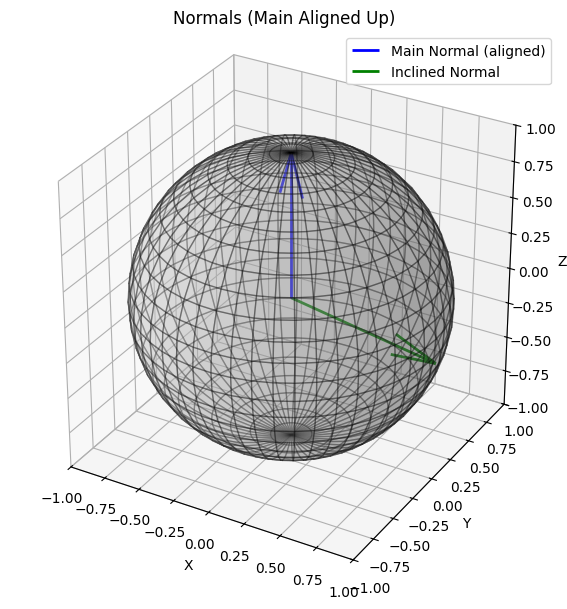

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

main_plane_model = segment_models[main_surface_idx]
main_normal = np.array(main_plane_model[:3])
main_normal /= np.linalg.norm(main_normal)

plane_1_model = segment_models[3]  # Example inclined plane model
plane_1_normal = np.array(plane_1_model[:3])
plane_1_normal /= np.linalg.norm(plane_1_normal)

dot = np.dot(main_normal, plane_1_normal)
angle = np.degrees(np.arccos(np.clip(dot, -1.0, 1.0)))
print(f"dot = {dot:.3f} → angle = {angle:.2f}°")

def plot_rotated_normals_on_sphere(n_main, n_inclined):
    # Normalize
    n_main = n_main / np.linalg.norm(n_main)
    n_inclined = n_inclined / np.linalg.norm(n_inclined)

    # Desired up direction
    target = np.array([0, 0, 1])

    # Compute rotation from n_main → target
    axis = np.cross(n_main, target)
    angle = np.arccos(np.clip(np.dot(n_main, target), -1.0, 1.0))

    if np.linalg.norm(axis) < 1e-6:
        rot = R.identity()  # already aligned
    else:
        axis = axis / np.linalg.norm(axis)
        rot = R.from_rotvec(angle * axis)

    # Apply rotation
    n_main_rot = rot.apply(n_main)
    n_inclined_rot = rot.apply(n_inclined)

    # Create unit sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot unit sphere
    ax.plot_surface(x, y, z, color='lightgrey', alpha=0.3, edgecolor='k')

    # Plot rotated normals
    ax.quiver(0, 0, 0, *n_main_rot, color='blue', linewidth=2, label='Main Normal (aligned)')
    ax.quiver(0, 0, 0, *n_inclined_rot, color='green', linewidth=2, label='Inclined Normal')

    # Format
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])
    ax.set_box_aspect([1,1,1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Normals (Main Aligned Up)')
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_rotated_normals_on_sphere(main_normal, plane_1_normal)